# Detección de anomalías en un marco de auditoría continua

## 7. Datos desbalanceados - Modelos supervisados

### 7.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 7.2. Entrenamiento de modelos

#### 7.2.1. Preparación del dataset y funciones

In [6]:
# F1 score, also known as balanced F-score or F-measure.
# The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
# F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Función objetivo.
def objective_func(search_space):
    
    global i, scorings
    start_time = time.time()
    i += 1
    
    estimator = search_space['estimator']
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator, 
                        X = X, 
                        y = y, 
                        cv = skf, 
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [7]:
# Función para la exportación de graficos a png.
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

def export_png(filename : 'str' = 'test', y_test = None, y_pred = None):

    # Obtención de la matriz de confusión
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels = ['No Fraude', 'Fraude'])

    fig = plt.figure(figsize = (10,6))
    ax = plt.axes()
    disp.plot(ax = ax, values_format = 'd', colorbar = False, cmap = 'tab20b')
    ax.set_title(label = 'Matriz de confusión', fontdict = {'fontsize' : 20})
    ax.set_xlabel(xlabel = 'Predicciones', fontdict = {'fontsize' : 14})
    ax.set_ylabel(ylabel = 'Observaciones', fontdict = {'fontsize' : 14})
    plt.savefig('.//figures//' + filename + '_confusion_matrix.png')

    # Obtención de la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    disp = RocCurveDisplay(fpr = fpr, tpr = tpr)

    fig = plt.figure(figsize = (10,6))
    ax = plt.axes()
    disp.plot(ax = ax, c = 'blue')
    ax.set_title(label = 'Curva ROC', fontdict = {'fontsize' : 20})
    ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14})
    ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14})
    plt.savefig('.//figures//' + filename + '_roc_curve.png')

    # Obtención de la curva Recall - Precision
    prec, recall, _ = precision_recall_curve(y_true = y_test, probas_pred = y_pred)
    disp = PrecisionRecallDisplay(precision = prec, recall = recall)

    fig = plt.figure(figsize = (10,6))
    ax = plt.axes()
    disp.plot(ax = ax, c = 'blue')
    ax.set_title(label = 'Curva Precision-Recall', fontdict = {'fontsize' : 20})
    ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14})
    ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14})
    plt.savefig('.//figures//' + filename + '_precision_recall.png')

In [32]:
from export import export_png

The script is called with 2 arguments


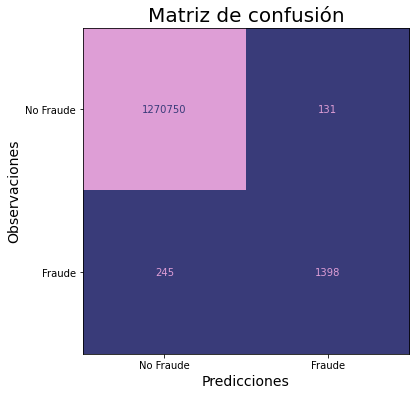

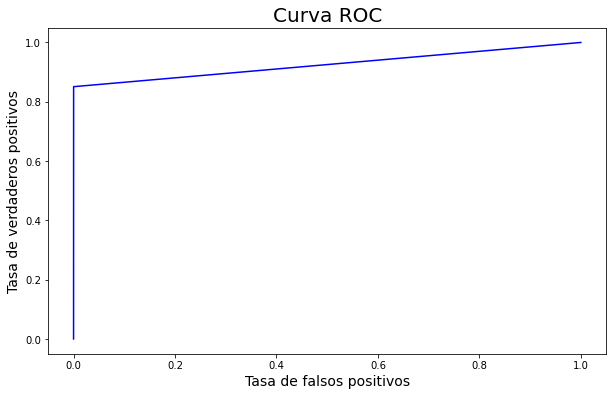

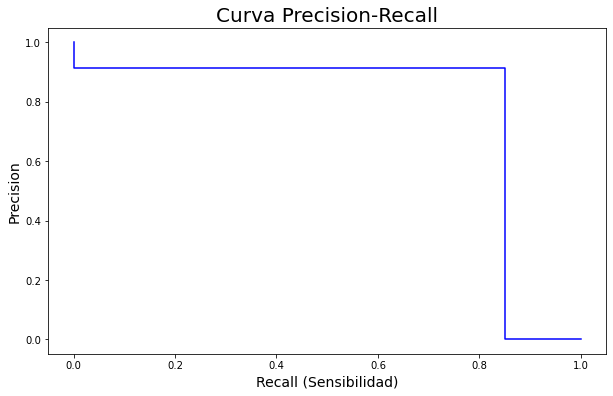

In [34]:
export_png('prueba', y_test, y_pred)

#### 7.2.2. Árboles de Decisión (Decision trees)

##### 7.2.2.1. Primera optimización de parámetros

Para la optimización de hiperparámetros, se utiliza una alternativa de búsqueda guidada, mediante la implementación de la librería HyperOpt y el algoritmo Tree Parzen Estimator, basado en la Optimización Bayesiana.

In [12]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : hp.choice('criterion', ['entropy', 'gini']),
                            'splitter' : hp.choice('splitter', ['best', 'random']),
                            'max_depth' : hp.qnormal('max_depth', 12, 5, 1),
                            'min_samples_split' : hp.choice('min_samples_split', [2, 3]),
                            'min_samples_leaf' : hp.choice('min_samples_leaf', [1, 2, 3]),
                            'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                            'random_state' : 42}}

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)

Trial: 0 | Loss: 0.1701 | Elapsed_time: 90.2560 seconds                                                                
Trial: 1 | Loss: 0.8823 | Elapsed_time: 27.6402 seconds                                                                
Trial: 2 | Loss: 0.2368 | Elapsed_time: 59.1000 seconds                                                                
Trial: 3 | Loss: 0.3031 | Elapsed_time: 20.9680 seconds                                                                
Trial: 4 | Loss: 0.1364 | Elapsed_time: 49.4291 seconds                                                                
Trial: 5 | Loss: 0.9819 | Elapsed_time: 17.9345 seconds                                                                
Trial: 6 | Loss: 0.2904 | Elapsed_time: 21.8808 seconds                                                                
Trial: 7 | Loss: 0.9369 | Elapsed_time: 16.1191 seconds                                                                
Trial: 8 | Loss: 0.1701 | Elapsed_time: 

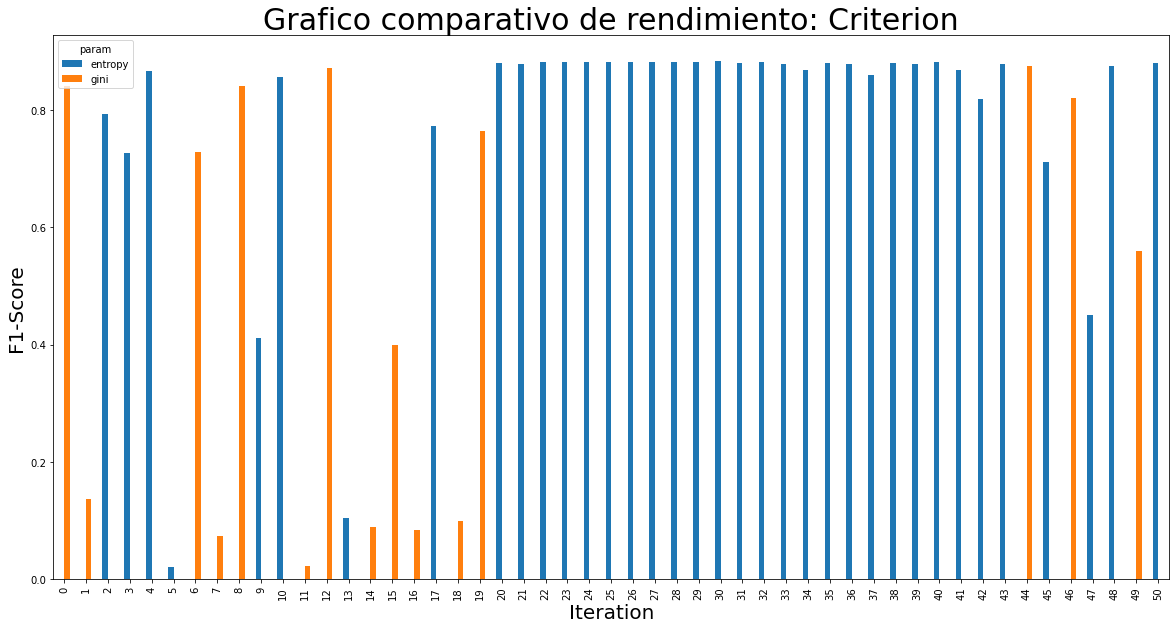

In [127]:
# Gráfico comparativo de rendimiento: Criterion.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['criterion'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Criterion')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

El criterio que clasifica mejor es 'entropy'.

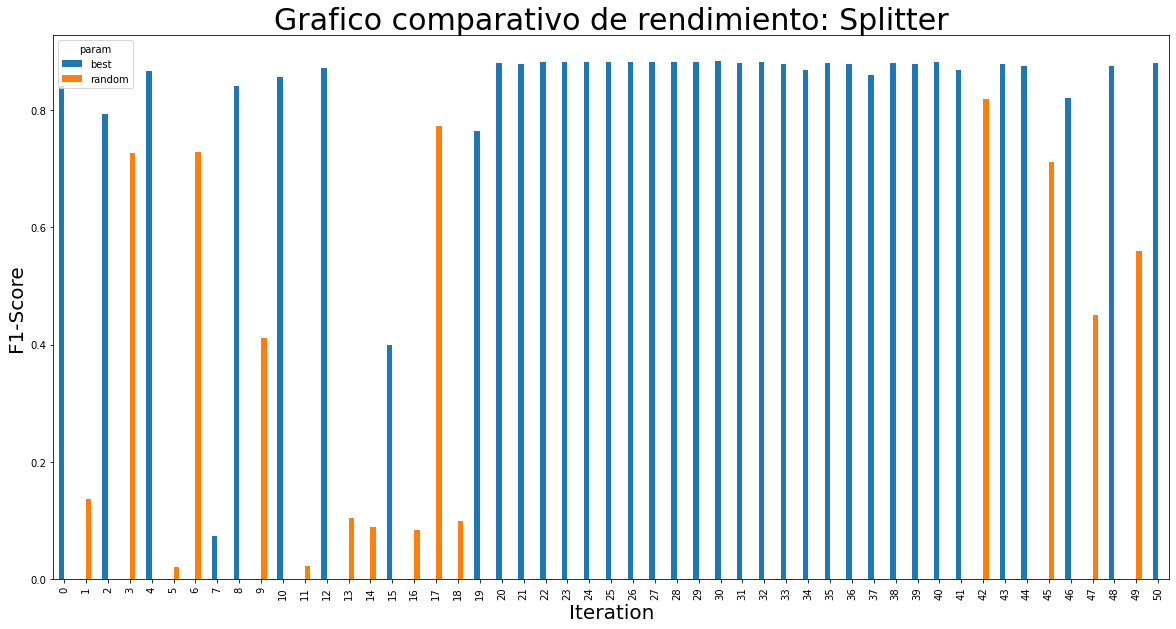

In [128]:
# Gráfico comparativo de rendimiento: Splitter.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['splitter'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Splitter')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

El splitter que clasifica mejor es "best".

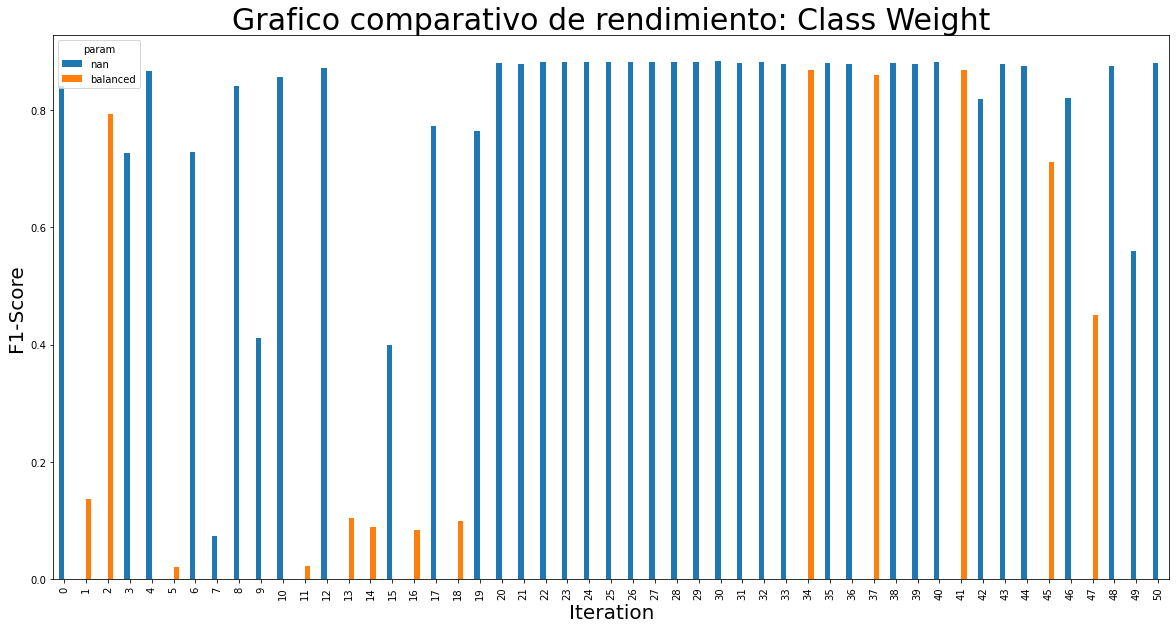

In [129]:
# Gráfico comparativo de rendimiento: Class_Weight.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['class_weight'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Class Weight')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

La no consideración de pesos por clases desbalanceadas otorga una mejor perfomance al modelo.

##### 7.2.2.2. Segunda optimización de hiperparámetros

In [8]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier
from math import log

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : hp.choice('criterion', ['entropy']),
                            'splitter' : hp.choice('splitter', ['best']),
                            'max_depth' : hp.qlognormal('max_depth', log(12), log(5), 1),
                            'min_samples_split' : hp.choice('min_samples_split', range(2, 11)),
                            'min_samples_leaf' : hp.choice('min_samples_leaf', range(2, 11)),
                            'class_weight' : hp.choice('class_weight', [None]),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)

Trial: 0 | Loss: 0.1344 | Elapsed_time: 53.3573 seconds                                                                
Trial: 1 | Loss: 0.1243 | Elapsed_time: 47.3222 seconds                                                                
Trial: 2 | Loss: 0.2578 | Elapsed_time: 34.9359 seconds                                                                
Trial: 3 | Loss: 0.1261 | Elapsed_time: 47.9579 seconds                                                                
Trial: 4 | Loss: 0.1311 | Elapsed_time: 47.4790 seconds                                                                
Trial: 5 | Loss: 0.3023 | Elapsed_time: 32.6075 seconds                                                                
Trial: 6 | Loss: 0.1341 | Elapsed_time: 43.4044 seconds                                                                
Trial: 7 | Loss: 1.0000 | Elapsed_time: 16.4131 seconds                                                                
Trial: 8 | Loss: 0.1548 | Elapsed_time: 

##### 7.2.2.3. Tercera optimización de hiperparámetros

In [10]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier
from math import log

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : 'entropy',
                            'splitter' : 'best',
                            'max_depth' : hp.qnormal('max_depth', 12, 5, 1),
                            'min_samples_split' : hp.choice('min_samples_split', [2, 3]),
                            'min_samples_leaf' : hp.choice('min_samples_leaf', [1, 2, 3]),
                            'class_weight' : None,
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)

Trial: 0 | Loss: 0.1334 | Elapsed_time: 51.9459 seconds                                                                
Trial: 1 | Loss: 0.1256 | Elapsed_time: 47.3608 seconds                                                                
Trial: 2 | Loss: 0.1508 | Elapsed_time: 48.3681 seconds                                                                
Trial: 3 | Loss: 0.1259 | Elapsed_time: 49.9709 seconds                                                                
Trial: 4 | Loss: 0.1236 | Elapsed_time: 48.2084 seconds                                                                
Trial: 5 | Loss: 0.1535 | Elapsed_time: 45.5335 seconds                                                                
Trial: 6 | Loss: 0.1253 | Elapsed_time: 46.7727 seconds                                                                
Trial: 7 | Loss: 0.2060 | Elapsed_time: 38.6676 seconds                                                                
Trial: 8 | Loss: 0.1463 | Elapsed_time: 

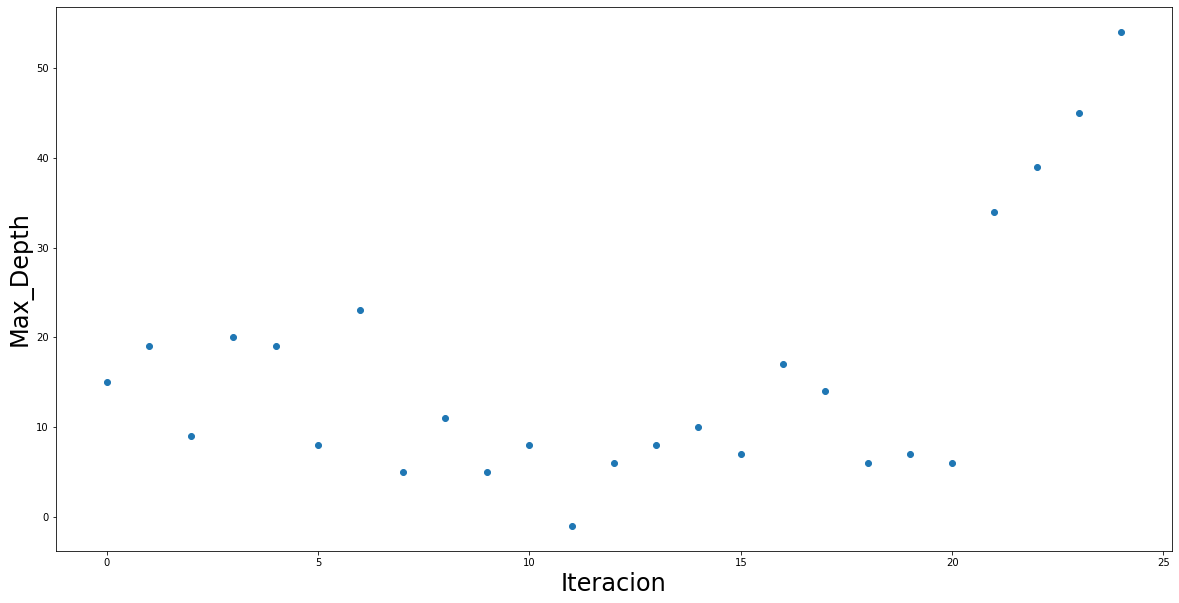

In [35]:
import matplotlib.pyplot as plt
max_depth_i = [eval(scoring['search_space'])['params']['max_depth'] for scoring in scorings]
fig = plt.figure(figsize = (20,10))
fig = plt.scatter(x = range(len(max_depth_i)), y = max_depth_i)
fig = plt.xlabel('Iteracion', size = 24)
fig = plt.ylabel('Max_Depth', size = 24)

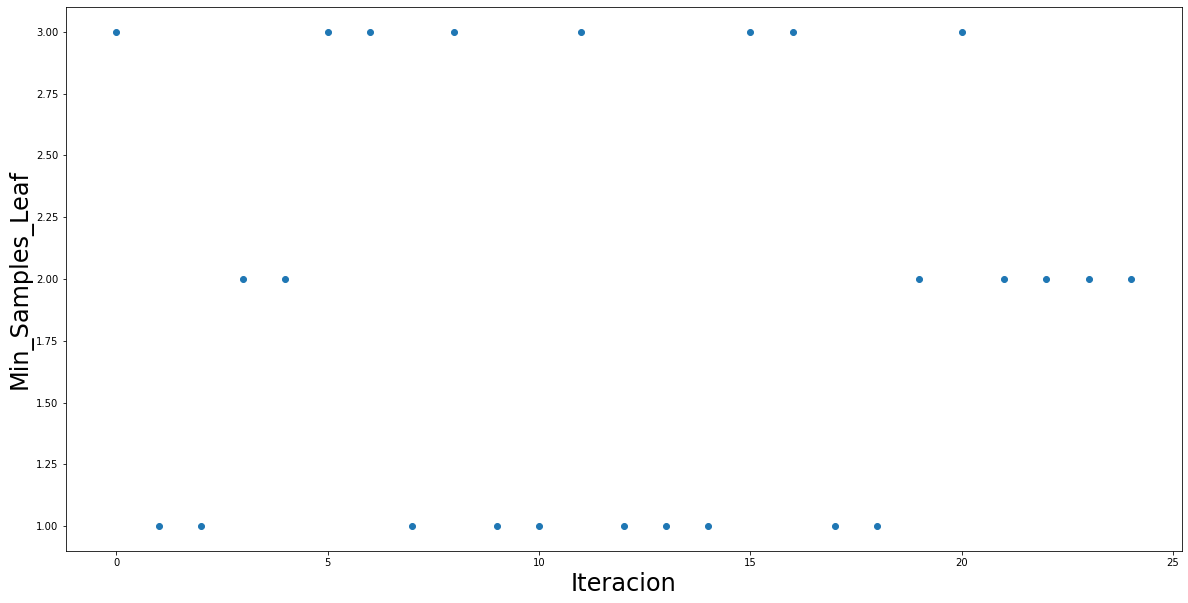

In [37]:
import matplotlib.pyplot as plt
min_samples_leaf_i = [eval(scoring['search_space'])['params']['min_samples_leaf'] for scoring in scorings]
fig = plt.figure(figsize = (20,10))
fig = plt.scatter(x = range(len(min_samples_leaf_i)), y = min_samples_leaf_i)
fig = plt.xlabel('Iteracion', size = 24)
fig = plt.ylabel('Min_Samples_Leaf', size = 24)

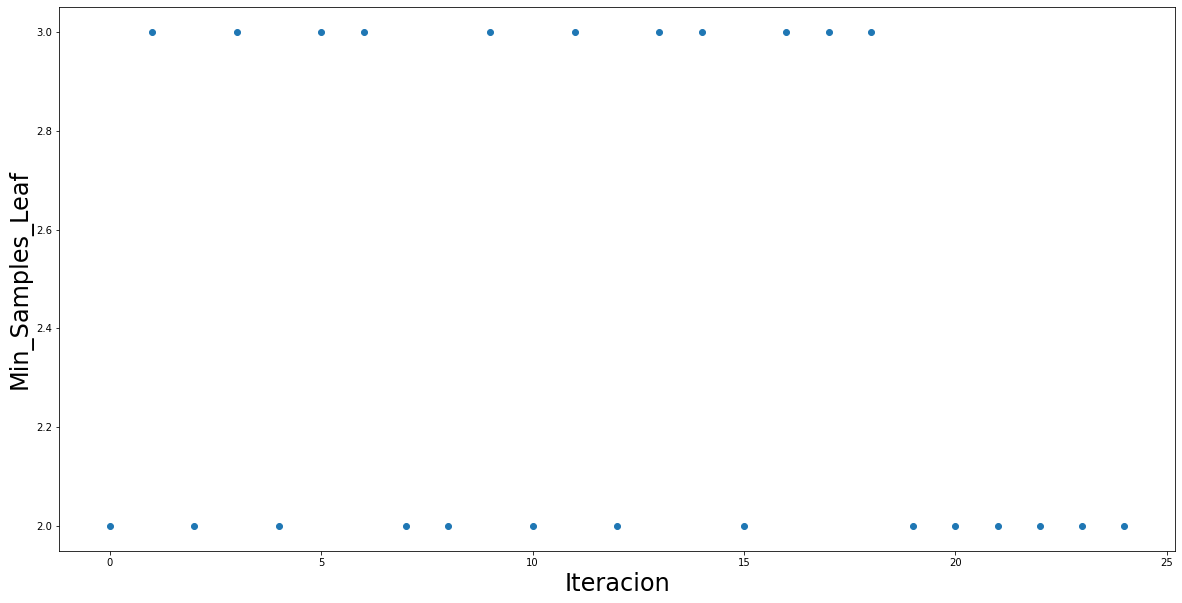

In [38]:
import matplotlib.pyplot as plt
min_samples_split_i = [eval(scoring['search_space'])['params']['min_samples_split'] for scoring in scorings]
fig = plt.figure(figsize = (20,10))
fig = plt.scatter(x = range(len(min_samples_split_i)), y = min_samples_split_i)
fig = plt.xlabel('Iteracion', size = 24)
fig = plt.ylabel('Min_Samples_Leaf', size = 24)

##### 7.2.2.4. Evaluación de perfomance con el conjunto de validación

Best Trial:
Trial ID : 4
Loss : 0.12358221898732565
Params : {'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=54.0, min_samples_leaf=2, random_state=42), 'params': {'class_weight': None, 'criterion': 'entropy', 'max_depth': 19.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}}

|--- amount <= 591031.81
|   |--- Transfer <= 0.50
|   |   |--- Cash_out <= 0.50
|   |   |   |--- weights: [2866741.00, 0.00] class: 0
|   |   |--- Cash_out >  0.50
|   |   |   |--- oldbalanceOrig <= 53062.46
|   |   |   |   |--- amount <= 52795.37
|   |   |   |   |   |--- oldbalanceOrig <= 1436.19
|   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |--- oldbalanceOrig >  1436.19
|   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |--- amount >  52795.37
|   |   |   |   |   |--- idOrig <= 764056.50
|   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |--- idOrig >  764056.50
|   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |--- oldbalanceOrig >  53062.46
|   |   |   |   |--- newbalanceOrig <= 0.44
|   |   |   |   |   |--- oldbalanceOrig <= 319883.55
|   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |--- oldbalanceOrig >  319883.55
|   |   |   |   |   |   |--- truncat

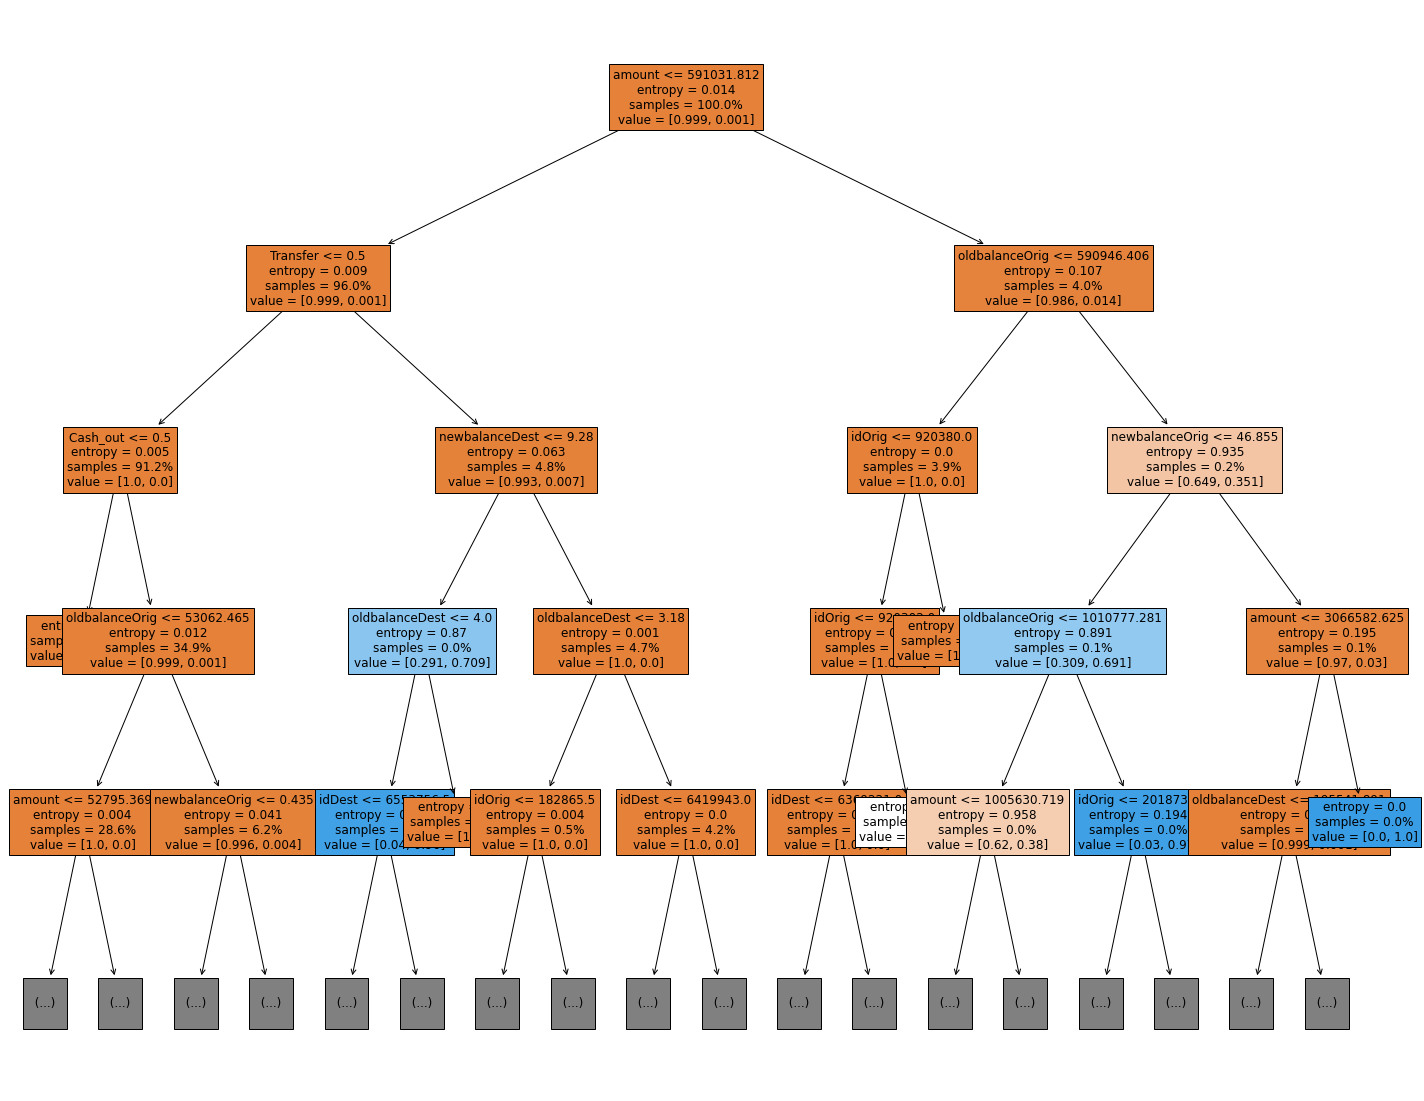

In [40]:
# Representación gráfica
# https://mljar.com/blog/visualize-decision-tree/

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree

params = {'class_weight' : None,
          'criterion' : 'entropy',
          'max_depth' : 19.0, 
          'min_samples_leaf' : 2, 
          'min_samples_split' : 2, 
          'random_state' : 42, 
          'splitter' : 'best'}

clf = DecisionTreeClassifier(**params)
clf.fit(X = X, y = y)

text_representation = export_text(clf, show_weights = True, max_depth = 5, feature_names = list(X.columns))
print(text_representation)

fig = plt.figure(figsize=(25,20))
fig = plot_tree(clf, max_depth = 4, fontsize = 12, feature_names = X.columns, proportion = True, filled = True)

In [41]:
# Weights de los atributos.
print(pd.DataFrame(data = (clf.feature_names_in_, clf.feature_importances_)).transpose().sort_values(1, ascending = False))

                 0         1
4   oldbalanceOrig  0.343804
2           amount  0.215296
8   newbalanceDest    0.1928
5   newbalanceOrig  0.073282
13        Transfer  0.068448
10        Cash_out  0.037542
7   oldbalanceDest  0.028069
3           idOrig  0.021636
0              day  0.011884
6           idDest  0.006428
1             hour  0.000809
9          Cash_in       0.0
11           Debit       0.0
12         Payment       0.0


In [42]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

X_test = df_validation.drop(labels = ['isFraud', 'isFlaggedFraud'], axis = 1, inplace = False)
y_test = df_validation['isFraud']

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.8509
Precision: 0.9143
AUC: 0.9254
Accuracy: 0.9997
F1-Score: 0.8815


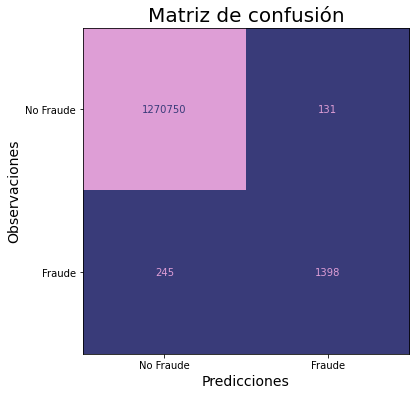

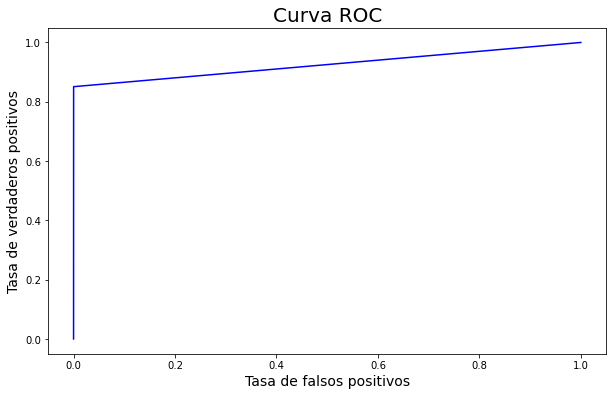

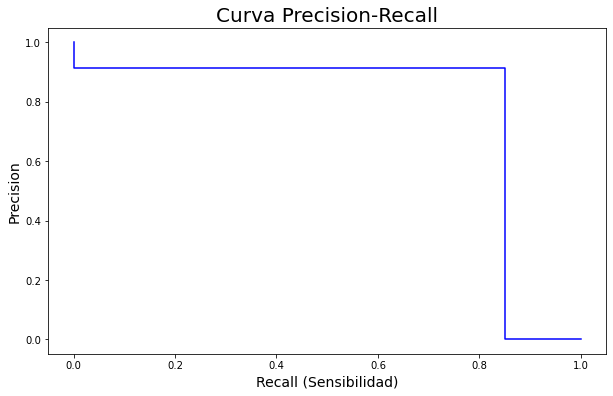

In [9]:
# Espacio de parámetros.
params = {'class_weight' : None,
          'criterion' : 'entropy',
          'max_depth' : 19.0, 
          'min_samples_leaf' : 2, 
          'min_samples_split' : 2, 
          'random_state' : 42, 
          'splitter' : 'best'}

selected_columns = ['isFraud', 'isFlaggedFraud']

# Configuración de los datos de entrenamiento y validación.
X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

# Entrenamiento del modelo.
clf = DecisionTreeClassifier(**params)
clf.fit(X = X_train, y = y_train)

# Predicción de valores.
y_pred = clf.predict(X_test)

# Exportación a png.
export_png(filename = 'decisiontree', y_test = y_test, y_pred = y_pred)

#### 7.2.3. SVM

Se evaluaron diversos modelos de clasificación de tipo SVM. De los resultados obtenidos, se decide utilizar el modelo LinearSVC por ofrecer el mejor rendimiento.

Se recurre al downsampling del dataset para incrementar el alcance del modelo, sin sacrificar rendimiento.

In [8]:
# https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

# Separate majority and minority classes
df_minority = df_training[df_training['isFraud'] == 1]
df_majority = df_training[df_training['isFraud'] == 0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace = False,    # sample without replacement
                                   n_samples = len(df_minority),     # to match minority class
                                   random_state = 42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.isFraud.value_counts()

0    6570
1    6570
Name: isFraud, dtype: int64

##### 7.2.3.1. Ingeniería de predictores Nro. 1

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [8]:
# Combinaciones de columnas.
import itertools

items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 
          'idDest', 'oldbalanceDest', 'newbalanceDest']

combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

In [44]:
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC

i = 0
scorings = []

for combination in combinations:
    
    start_time = time.time()
    
    df_dropped = df_downsampled.drop(combination, axis = 1)
    
    estimator = LinearSVC(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator,
                        X = df_dropped.drop(['isFraud', 'isFlaggedFraud'], axis = 1),
                        y = df_dropped['isFraud'], 
                        cv = skf,
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))

    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()
    
    scorings.append({'trial': i,
                     'search_space' : combination,
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))   
    
    i += 1

Trial: 0 | Loss: 0.2154 | Elapsed_time: 0.4163 seconds
Trial: 1 | Loss: 0.2154 | Elapsed_time: 0.3474 seconds
Trial: 2 | Loss: 0.2154 | Elapsed_time: 0.3838 seconds
Trial: 3 | Loss: 0.2461 | Elapsed_time: 0.3798 seconds
Trial: 4 | Loss: 0.4698 | Elapsed_time: 0.4380 seconds
Trial: 5 | Loss: 0.4397 | Elapsed_time: 0.5476 seconds
Trial: 6 | Loss: 0.2297 | Elapsed_time: 0.3584 seconds
Trial: 7 | Loss: 0.1951 | Elapsed_time: 0.4017 seconds
Trial: 8 | Loss: 0.2890 | Elapsed_time: 0.4031 seconds
Trial: 9 | Loss: 0.2154 | Elapsed_time: 0.3582 seconds
Trial: 10 | Loss: 0.2461 | Elapsed_time: 0.3140 seconds
Trial: 11 | Loss: 0.4698 | Elapsed_time: 0.4228 seconds
Trial: 12 | Loss: 0.4397 | Elapsed_time: 0.4868 seconds
Trial: 13 | Loss: 0.2097 | Elapsed_time: 0.3906 seconds
Trial: 14 | Loss: 0.1951 | Elapsed_time: 0.3660 seconds
Trial: 15 | Loss: 0.2890 | Elapsed_time: 0.3322 seconds
Trial: 16 | Loss: 0.2461 | Elapsed_time: 0.3374 seconds
Trial: 17 | Loss: 0.4698 | Elapsed_time: 0.4221 seconds
Tr

In [50]:
# Impresión de reportes.
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Json file: 20220407_200947.json

Scoring details:

       Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0    0.878418  0.819733  0.961917  0.810654   0.111411      0.154225  0.003347     0.069849  0.827575
1    0.878418  0.819733  0.961917  0.810654   0.111411      0.154225  0.003347     0.069849  0.827575
2    0.878418  0.819733  0.961917  0.810654   0.111411      0.154225  0.003347     0.069849  0.827575
3    0.854488  0.809681  0.962677  0.778615   0.133266      0.177166  0.005572     0.100399  0.802377
4    0.553676  0.844565  0.796969  0.671309   0.248396      0.163936   0.04241      0.04116  0.606385
5    0.767311  0.683024  0.813005   0.62344   0.259361      0.183365  0.023929     0.075108  0.652674
6    0.896972  0.847178  0.946036  0.836834    0.11752      0.151728  0.031489     0.115663  0.853302
7    0.784767  0.902866  0.950819  0.830898   0.095863      0.126063  0.009791     0.044165  0.825134
8    0.863624  0.739072  0.9486

In [53]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
207,0.973515,0.969918,0.980947,0.971157,0.013152,0.026855,0.001573,0.011716,0.971372
228,0.985085,0.946699,0.982777,0.963546,0.00713,0.043302,0.003672,0.021564,0.964846
81,0.935329,0.921578,0.953209,0.924429,0.084646,0.048187,0.030688,0.02269,0.92378
80,0.907435,0.943863,0.960144,0.927778,0.128423,0.029219,0.026831,0.069961,0.921491
136,0.919462,0.915663,0.91395,0.90723,0.099175,0.100512,0.102647,0.06359,0.909147
...,...,...,...,...,...,...,...,...,...
238,0.263854,0.332707,0.326314,0.543075,0.422939,0.254124,0.221958,0.16764,0.239249
233,0.28667,0.372689,0.447698,0.508067,0.412519,0.314059,0.210293,0.043985,0.236665
205,0.20994,0.421934,0.37999,0.518798,0.290308,0.287485,0.158843,0.084597,0.224997
216,0.144901,0.667791,0.435115,0.529604,0.08027,0.065622,0.105317,0.011757,0.223383


In [68]:
# Impresion de mejor combinacion de atributos
print('Mejor combinacion de atributos a eliminar: ', *combinations[207])

Mejor combinacion de atributos a eliminar:  hour idOrig idDest oldbalanceDest newbalanceDest


##### 7.2.3.2. Ingeniería de predictores Nro. 2

Se evalua el impacto de la aplicación de distintos métodos de estandarización de atributos.

Escalamiento de atributos a un mínimo de 0 y máximo de 1.

Se eliminan las columnas 'hour', 'idOrig', 'idDest', 'oldbalanceDest' y 'newbalanceDest'.

In [67]:
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

i = 0
scorings = []
selected_columns = ['hour', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scalers = [None, MinMaxScaler((0, 1)), MinMaxScaler((-1, 1)), MaxAbsScaler(), StandardScaler(), RobustScaler()]

for scaler in scalers:
    
    start_time = time.time()
    
    X_ = df_downsampled.drop(selected_columns, axis = 1)
    y_ = df_downsampled['isFraud']
    
    if scaler is not None:
        X_ = scaler.fit_transform(X_)
        X_ = pd.DataFrame(X_)
        
    estimator = LinearSVC(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator,
                        X = X_,
                        y = y_,
                        cv = skf,
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))

    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()
    
    scorings.append({'trial': i,
                     'search_space' : scaler,
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Scaler: %s | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, scaler, loss, elapsed_time))   
    
    i += 1

Trial: 0 | Scaler: None | Loss: 0.0398 | Elapsed_time: 0.3071 seconds
Trial: 1 | Scaler: MinMaxScaler() | Loss: 0.1517 | Elapsed_time: 0.0500 seconds
Trial: 2 | Scaler: MinMaxScaler(feature_range=(-1, 1)) | Loss: 0.1225 | Elapsed_time: 0.0908 seconds
Trial: 3 | Scaler: MaxAbsScaler() | Loss: 0.1515 | Elapsed_time: 0.0460 seconds
Trial: 4 | Scaler: StandardScaler() | Loss: 0.0704 | Elapsed_time: 0.2200 seconds
Trial: 5 | Scaler: RobustScaler() | Loss: 0.0388 | Elapsed_time: 0.2070 seconds


El método de estandarización RobustScaler parecería producir mejores resultados que con el dataset original.

##### 7.2.3.3. Primera optimización de hiperparámetros

Se evaluan hiperparámetros del modelo.

Penalty L1 no se considera ya que arroja valores nulos como resultado.

In [17]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler
from math import log

# Ingeniería de predictores
selected_columns = ['hour', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()
X = df_downsampled.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = df_downsampled['isFraud']

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : LinearSVC(),
                'params' : {'penalty' : hp.choice('penalty', ['l2']),
                            'loss' : hp.choice('loss', ['hinge', 'squared_hinge']),
                            'C' : hp.lognormal('C', log(1.01), log(1.01)),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.0528 | Elapsed_time: 0.1980 seconds                                                                 
Trial: 1 | Loss: 0.0896 | Elapsed_time: 0.2063 seconds                                                                 
Trial: 2 | Loss: 0.0505 | Elapsed_time: 0.2211 seconds                                                                 
Trial: 3 | Loss: 0.0856 | Elapsed_time: 0.2070 seconds                                                                 
Trial: 4 | Loss: 0.0513 | Elapsed_time: 0.1700 seconds                                                                 
Trial: 5 | Loss: 0.0409 | Elapsed_time: 0.2152 seconds                                                                 
Trial: 6 | Loss: 0.1125 | Elapsed_time: 0.2102 seconds                                                                 
Trial: 7 | Loss: 0.0493 | Elapsed_time: 0.1935 seconds                                                                 
Trial: 8 | Loss: 0.0533 | Elapsed_time: 

##### 7.2.3.4. Segunda optimización de hiperparámetros

In [19]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler
from math import log

# Ingeniería de predictores
selected_columns = ['hour', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()
X = df_downsampled.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = df_downsampled['isFraud']

# Best Trial:
# Trial ID : 48
# Loss : 0.03880940791300415
# Params : {'estimator': LinearSVC(C=1.0125142162645848, loss='hinge', random_state=42), 
# 'params': {'C': 1.0133302917779023, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 42}}

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : LinearSVC(),
                'params' : {'penalty' : 'l2',
                            'loss' : 'squared_hinge',
                            'C' : 1.0133302917779023,
                            'random_state' : 42,
                            'dual' : hp.choice('dual', [True, False]),
                            'tol' : hp.normal('tol', 0.0001, 0.00001),
                            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
                            'intercept_scaling' : hp.normal('intercept_scaling', 1, 0.01),
                            'class_weight' : hp.choice('class_weight', ['balanced', None]),
                            'max_iter' : hp.randint('max_iter', 10, 2000)
                            }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(100), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.0916 | Elapsed_time: 0.2380 seconds                                                                 
Trial: 1 | Loss: 0.2006 | Elapsed_time: 0.0340 seconds                                                                 
Trial: 2 | Loss: 0.1976 | Elapsed_time: 0.0350 seconds                                                                 
Trial: 3 | Loss: 0.0398 | Elapsed_time: 0.0730 seconds                                                                 
Trial: 4 | Loss: 0.0414 | Elapsed_time: 0.1940 seconds                                                                 
Trial: 5 | Loss: 0.1981 | Elapsed_time: 0.0370 seconds                                                                 
Trial: 6 | Loss: 0.0398 | Elapsed_time: 0.0580 seconds                                                                 
Trial: 7 | Loss: 0.0391 | Elapsed_time: 0.2836 seconds                                                                 
Trial: 8 | Loss: 0.0785 | Elapsed_time: 

##### 7.2.3.5. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 72
Loss : 0.03797479495894093
Params : {'estimator': LinearSVC(C=1.0133302917779023, class_weight='balanced', fit_intercept=False,
          intercept_scaling=0.9562237889362558, max_iter=1804, random_state=42,
          tol=4.336605247844816e-05), 'params': {'C': 1.0133302917779023, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'intercept_scaling': 0.944325842815949, 'loss': 'squared_hinge', 'max_iter': 233, 'penalty': 'l2', 'random_state': 42, 'tol': 0.00010786938279906948}}

In [21]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Best Trial: Trial ID : 72 Loss : 0.03797479495894093 Params : {'estimator': LinearSVC(C=1.0133302917779023, class_weight='balanced', 
# fit_intercept=False, intercept_scaling=0.9562237889362558, max_iter=1804, random_state=42, tol=4.336605247844816e-05), 
# 'params': 

params = {'C': 1.0133302917779023, 
          'class_weight': 'balanced', 
          'dual': True, 
          'fit_intercept': False, 
          'intercept_scaling': 0.944325842815949, 
          'loss': 'squared_hinge', 
          'max_iter': 233, 
          'penalty': 'l2', 
          'random_state': 42, 
          'tol': 0.00010786938279906948}

clf = LinearSVC(**params)

selected_columns = ['hour', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()
X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
y_test = df_validation['isFraud']

clf.fit(X = X_train, y = y_train)

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.8795
Precision: 0.1393
AUC: 0.9362
Accuracy: 0.9928
F1-Score: 0.2405


#### 7.2.4. Redes neuronales

##### 7.2.4.1. Ejecución inicial

In [49]:
# Ejecución inicial.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = df_training.iloc[:,:-2]
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training.iloc[:, -2]

clf = MLPClassifier(random_state = 42)
skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
cv = cross_validate(estimator = clf, X = X_train, y = y_train, cv = skf, verbose = False, n_jobs = -1, 
                    scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
cv

{'fit_time': array([242.48997283, 294.21017623, 283.23449874, 268.2975781 ]),
 'score_time': array([5.81161427, 3.9778583 , 4.4801774 , 5.1552248 ]),
 'test_precision': array([0.93521127, 0.98264984, 0.95893372, 0.9875    ]),
 'test_recall': array([0.80876979, 0.75883069, 0.81010347, 0.76932441]),
 'test_roc_auc': array([0.99932981, 0.99798115, 0.99763478, 0.99858013]),
 'test_accuracy': array([0.99968095, 0.99967152, 0.99971003, 0.99968959]),
 'test_f1': array([0.86740692, 0.85635739, 0.878258  , 0.86486486])}

##### 7.2.4.2. Ingeniería de predictores Nro. 1

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [8]:
# Combinaciones de columnas.
import itertools

items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']

combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

In [13]:
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier

i = 0
scorings = []

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.01, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

for combination in combinations:
    
    start_time = time.time()
    
    X_dropped = X.drop(combination, axis = 1)
    
    estimator = MLPClassifier(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator,
                        X = X_dropped,
                        y = y,
                        cv = skf,
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))

    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()
    
    scorings.append({'trial': i,
                     'search_space' : combination,
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))   
    
    i += 1

Trial: 0 | Loss: 0.4865 | Elapsed_time: 8.0528 seconds
Trial: 1 | Loss: 0.4083 | Elapsed_time: 7.5035 seconds
Trial: 2 | Loss: 0.4076 | Elapsed_time: 7.5127 seconds
Trial: 3 | Loss: 0.7541 | Elapsed_time: 7.2210 seconds
Trial: 4 | Loss: 0.6822 | Elapsed_time: 2.4302 seconds
Trial: 5 | Loss: 0.7592 | Elapsed_time: 2.2401 seconds
Trial: 6 | Loss: 0.6195 | Elapsed_time: 2.7389 seconds
Trial: 7 | Loss: 0.5680 | Elapsed_time: 4.8140 seconds
Trial: 8 | Loss: 0.5880 | Elapsed_time: 4.6381 seconds
Trial: 9 | Loss: 0.4905 | Elapsed_time: 4.6729 seconds
Trial: 10 | Loss: 0.8787 | Elapsed_time: 4.8680 seconds
Trial: 11 | Loss: 0.9183 | Elapsed_time: 4.1765 seconds
Trial: 12 | Loss: 0.6863 | Elapsed_time: 6.7366 seconds
Trial: 13 | Loss: 0.6099 | Elapsed_time: 5.2242 seconds
Trial: 14 | Loss: 0.6650 | Elapsed_time: 4.0162 seconds
Trial: 15 | Loss: 0.5423 | Elapsed_time: 5.3995 seconds
Trial: 16 | Loss: 0.6735 | Elapsed_time: 4.3978 seconds
Trial: 17 | Loss: 0.9008 | Elapsed_time: 5.4723 seconds
Tr

In [14]:
# Impresión de reportes.
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Json file: 20220410_164705.json

Scoring details:

       Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0    0.511949  0.840278  0.755746  0.998919   0.149912      0.276647  0.074571     0.000602  0.571179
1    0.514706  0.921875  0.757304  0.999273    0.09534      0.135316  0.047602     0.000116  0.644674
2    0.589154  0.741319  0.794416  0.999155   0.061977      0.151937  0.030932     0.000179  0.646667
3    0.483456  0.730967  0.740885  0.997662   0.286311      0.345823   0.14201     0.002465  0.413203
4    0.332721   0.56746  0.666079  0.998585   0.123052      0.254123  0.061317     0.000266  0.367152
5    0.288603  0.759959  0.644193  0.998861   0.115487      0.266854  0.057756     0.000322  0.392032
6    0.530331  0.416564  0.764267  0.998134   0.078265       0.13395  0.038727     0.000734  0.441115
7    0.395221  0.896104  0.697571  0.999136   0.103253       0.11359  0.051607     0.000147  0.535197
8    0.442096  0.673485  0.7208

In [15]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False).head(10)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
20,0.586397,0.84375,0.793108,0.999293,0.208905,0.106677,0.104412,0.0002,0.656207
2,0.589154,0.741319,0.794416,0.999155,0.061977,0.151937,0.030932,0.000179,0.646667
46,0.679228,0.630103,0.839319,0.998998,0.121306,0.188855,0.060754,0.000456,0.644872
1,0.514706,0.921875,0.757304,0.999273,0.09534,0.135316,0.047602,0.000116,0.644674
9,0.606618,0.715023,0.803056,0.998998,0.085196,0.21818,0.042541,0.000562,0.630919
25,0.622243,0.679196,0.810805,0.99888,0.115601,0.285435,0.057778,0.000599,0.613757
61,0.591912,0.722731,0.795736,0.999037,0.23115,0.204567,0.1155,0.000366,0.593067
36,0.528493,0.784821,0.764069,0.999037,0.140101,0.198373,0.069812,0.000306,0.589957
72,0.482537,0.886364,0.741164,0.999136,0.130848,0.196824,0.065246,0.000184,0.588217
26,0.442096,0.927083,0.721018,0.999214,0.11863,0.07439,0.059285,0.000111,0.583874


In [16]:
best = scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False).head(10).index

print([combinations[i] for i in best])

[['hour', 'oldbalanceDest'], ['hour'], ['day', 'idOrig', 'oldbalanceDest'], ['day'], ['day', 'hour'], ['idOrig', 'oldbalanceDest'], ['hour', 'idOrig', 'oldbalanceDest'], ['oldbalanceDest', 'newbalanceDest'], ['hour', 'oldbalanceDest', 'newbalanceDest'], ['idOrig', 'newbalanceDest']]


De la lectura de los scorings y observando que eliminación de columnas produce mejores resultados, se decide eliminar: "day", "hour", "idOrig", idDest".

##### 7.2.4.3. Ingeniería de predictores Nro. 2

Se procede a optimizar el criterio de transformación de las dimensiones del dataset.

In [17]:
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

i = 0
scorings = []

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

selected_columns = ['day', 'hour', 'idOrig', 'idDest', 'isFraud', 'isFlaggedFraud']
X_dropped = X.drop(selected_columns, axis = 1)
scalers = [None, MaxAbsScaler(), MinMaxScaler((0,1)), MinMaxScaler((-1,1)), Normalizer(), RobustScaler(), StandardScaler()]

for scaler in scalers:
    
    start_time = time.time()
    
    if scaler is not None:
        X_scaled = scaler.fit_transform(X_dropped)
        X_scaled = pd.DataFrame(X_scaled)
    else:
        X_scaled = X_dropped
    
    estimator = MLPClassifier(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator,
                        X = X_scaled,
                        y = y,
                        cv = skf,
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))

    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()
    
    scorings.append({'trial': i,
                     'search_space' : scaler,
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))   
    
    i += 1

Trial: 0 | Loss: 0.6423 | Elapsed_time: 79.2421 seconds
Trial: 1 | Loss: 0.5380 | Elapsed_time: 44.5588 seconds
Trial: 2 | Loss: 0.5380 | Elapsed_time: 38.8870 seconds
Trial: 3 | Loss: 0.8111 | Elapsed_time: 38.6099 seconds
Trial: 4 | Loss: 1.1457 | Elapsed_time: 31.2316 seconds
Trial: 5 | Loss: 0.2303 | Elapsed_time: 43.1527 seconds
Trial: 6 | Loss: 0.3708 | Elapsed_time: 35.6181 seconds


In [18]:
# Impresión de reportes.
scorings_df = scorings_to_df(scorings)

Scoring details:

     Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0  0.637574  0.457938  0.918474     0.998   0.128853       0.27222  0.035893     0.000805  0.478102
1  0.333315  0.941938  0.976198  0.999112   0.027823      0.035596  0.003479     0.000034  0.491461
2  0.333315  0.941938  0.976205  0.999112   0.027823      0.035596   0.00349     0.000034  0.491461
3  0.117193  0.919022  0.953522  0.998847   0.011641      0.061591  0.006158      0.00002  0.207661
4  0.199695  0.198485  0.991096    0.9989   0.345882      0.343786  0.005474     0.000331  0.199088
5  0.671231  0.970011  0.994471  0.999548   0.035303      0.021192  0.003932     0.000041  0.792674
6  0.500822  0.972177  0.986544  0.999336   0.039829      0.019999   0.00488      0.00004  0.659708


En base a los resultados, se decide utilizar el transformador RobustScaler.

##### 7.2.4.4. Optimización de hiperparámetros

In [12]:
# Importación de librerías
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
X = X.drop(selected_columns, axis = 1)
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
    
# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : MLPClassifier(),
                'params' : {'activation' : hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
                            'solver' : hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
                            'alpha' : hp.normal('alpha', 0.0001, 0.00001),
                            'hidden_layer_sizes' : (hp.randint('hl1', 1, 10), hp.randint('hl2', 1, 10), hp.randint('hl3', 1, 10)),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 1.0000 | Elapsed_time: 4.4626 seconds 
Trial: 1 | Loss: 0.1752 | Elapsed_time: 30.7736 seconds           
Trial: 2 | Loss: 0.1520 | Elapsed_time: 37.2352 seconds                          
Trial: 3 | Loss: 0.5041 | Elapsed_time: 11.1275 seconds                           
Trial: 4 | Loss: 1.0000 | Elapsed_time: 2.8844 seconds                            
Trial: 5 | Loss: 0.2236 | Elapsed_time: 21.9506 seconds                           
Trial: 6 | Loss: 0.4620 | Elapsed_time: 16.6911 seconds                           
Trial: 7 | Loss: 1.0000 | Elapsed_time: 19.3664 seconds                           
Trial: 8 | Loss: 0.4356 | Elapsed_time: 15.8275 seconds                           
Trial: 9 | Loss: 0.2998 | Elapsed_time: 23.5308 seconds                           
Trial: 10 | Loss: 1.0000 | Elapsed_time: 2.1786 seconds                            
Trial: 11 | Loss: 0.2393 | Elapsed_time: 35.7664 seconds                           
Trial: 12 | Loss: 1.0000 | Elapsed_time: 17.84

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
0,0.000000,0.000000,0.755352,0.998709,0.000000,0.000000,0.022122,0.000003,0.000000
1,0.748790,0.936301,0.992154,0.999607,0.027904,0.035192,0.007191,0.000016,0.830997
2,0.889135,0.951677,0.988221,0.999802,0.094375,0.040278,0.006733,0.000163,0.918302
3,0.363775,0.869516,0.966521,0.999108,0.013860,0.028113,0.006982,0.000030,0.512816
4,0.000000,0.000000,0.753166,0.998709,0.000000,0.000000,0.007909,0.000003,0.000000
5,0.716935,0.915849,0.982744,0.999548,0.042277,0.030093,0.009329,0.000057,0.803283
6,0.442951,0.835379,0.985162,0.999169,0.038228,0.037764,0.003364,0.000069,0.578522
7,0.000000,0.000000,0.203633,0.998709,0.000000,0.000000,0.009703,0.000003,0.000000
8,0.447524,0.887965,0.988442,0.999214,0.033133,0.010152,0.006114,0.000043,0.594499
9,0.585966,0.949020,0.980997,0.999424,0.032334,0.019270,0.007144,0.000036,0.723832


##### 7.2.4.5. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 26
Loss : 0.057512510635136724
Params : {'estimator': MLPClassifier(alpha=0.00012479830871276726, hidden_layer_sizes=(6, 3, 2),
           random_state=42, solver='lbfgs'), 'params': {'activation': 'tanh', 'alpha': 0.0001285548950868371, 'hidden_layer_sizes': (3, 3, 6), 'random_state': 42, 'solver': 'lbfgs'}}

In [9]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

# Configuración del estimador.
params = {'activation': 'tanh', 
          'alpha': 0.0001285548950868371, 
          'hidden_layer_sizes': (3, 3, 6), 
          'random_state': 42, 
          'solver': 'lbfgs'}
clf = MLPClassifier(**params)

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
y_test = df_validation['isFraud']

# Entrenamiento y obtención de métricas.
clf.fit(X = X_train, y = y_train)
y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9787
Precision: 0.8379
AUC: 0.9892
Accuracy: 0.9997
F1-Score: 0.9029


#### 7.2.5. Ensambles: Random Forest

In [6]:
# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Redefinición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator
    start_time = time.time()
    i += 1
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator, 
                        X = X, 
                        y = y, 
                        cv = skf, 
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

##### 7.2.5.1. Primera optimización de hiperparámetros

In [35]:
# Importación de librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from math import log

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud']

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

X = X.drop(selected_columns, axis = 1)
    
# Definición del espacio / dominio de parámetros.
estimator = RandomForestClassifier()
search_space = {'params' : {'n_estimators' : hp.randint('n_estimators', 1, 100),
                            'max_depth' : hp.qlognormal('max_depth', log(10), log(2), 1),
                            'min_samples_leaf' : hp.randint('min_samples_leaf', 1, 5),
                            'min_samples_split' : hp.randint('min_samples_split', 2, 5),              
                            'class_weight' : hp.choice('class_weight', ['balanced', None]),
                            'criterion' : hp.choice('criterion', ['entropy', 'gini']),
                            'max_features' : hp.uniform('max_features', 0.1, 1),
                            'max_samples' : hp.uniform('max_samples', 0.1, 1),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.2211 | Elapsed_time: 6.4527 seconds 
Trial: 1 | Loss: 0.2033 | Elapsed_time: 49.9256 seconds                           
Trial: 2 | Loss: 0.6497 | Elapsed_time: 4.7218 seconds                            
Trial: 3 | Loss: 0.1791 | Elapsed_time: 66.8672 seconds                           
Trial: 4 | Loss: 0.1899 | Elapsed_time: 13.9500 seconds                             
Trial: 5 | Loss: 0.1804 | Elapsed_time: 63.8850 seconds                             
Trial: 6 | Loss: 0.2162 | Elapsed_time: 54.0610 seconds                             
Trial: 7 | Loss: 0.2172 | Elapsed_time: 46.2274 seconds                             
Trial: 8 | Loss: 0.4466 | Elapsed_time: 1.9490 seconds                              
Trial: 9 | Loss: 0.1764 | Elapsed_time: 80.9871 seconds                             
Trial: 10 | Loss: 0.1662 | Elapsed_time: 6.3118 seconds                              
Trial: 11 | Loss: 0.3748 | Elapsed_time: 19.9156 seconds                             
Trial: 12 | L

##### 7.2.5.2. Segunda optimización de hiperparámetros

Best Trial:
Trial ID : 65
Loss : 0.1429831701459695
Params : {'params': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 352.0, 'max_features': 0.9291134341710399, 'max_samples': 0.8461053136089318, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 74, 'random_state': 42}}

In [11]:
# Importación de librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from math import log

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.02, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud']

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

X = X.drop(selected_columns, axis = 1)
    
# Definición del espacio / dominio de parámetros.
estimator = RandomForestClassifier()
search_space = {'params' : {'n_estimators' : 74,
                            'max_depth' : 352,
                            'min_samples_leaf' : 4,
                            'min_samples_split' : 4,              
                            'class_weight' : 'balanced',
                            'criterion' : 'entropy',
                            'max_features' : 0.9291134341710399,
                            'max_samples' : 0.8461053136089318,
                            'random_state' : 42,
                            'ccp_alpha' : hp.randint('ccp_alpha', 0, 100) / 1000
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.4709 | Elapsed_time: 12.4011 seconds
Trial: 1 | Loss: 0.9653 | Elapsed_time: 13.4438 seconds                           
Trial: 2 | Loss: 0.7997 | Elapsed_time: 13.8689 seconds                           
Trial: 3 | Loss: 0.9522 | Elapsed_time: 13.1930 seconds                           
Trial: 4 | Loss: 0.9215 | Elapsed_time: 12.6917 seconds                           
Trial: 5 | Loss: 0.9570 | Elapsed_time: 11.7015 seconds                           
Trial: 6 | Loss: 0.9575 | Elapsed_time: 11.6502 seconds                           
Trial: 7 | Loss: 0.9492 | Elapsed_time: 12.0083 seconds                           
Trial: 8 | Loss: 0.5543 | Elapsed_time: 11.4797 seconds                           
Trial: 9 | Loss: 0.9657 | Elapsed_time: 11.5096 seconds                           
Trial: 10 | Loss: 0.6975 | Elapsed_time: 11.5974 seconds                           
Trial: 11 | Loss: 0.9657 | Elapsed_time: 11.5353 seconds                           
Trial: 12 | Loss: 0.9321 | El

##### 7.2.5.3. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 20
Loss : 0.3232296617843831
Params : {'params': {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 352, 'max_features': 0.9291134341710399, 'max_samples': 0.8461053136089318, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 74, 'random_state': 42}}

In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
params = {'n_estimators' : 74,
          'max_depth' : 352,
          'min_samples_leaf' : 4,
          'min_samples_split' : 4,              
          'class_weight' : 'balanced',
          'criterion' : 'entropy',
          'max_features' : 0.9291134341710399,
          'max_samples' : 0.8461053136089318,
          'random_state' : 42,
          'ccp_alpha' : 0.0
         }

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud']

X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

clf = RandomForestClassifier(**params, n_jobs = -1)
clf.fit(X = X_train, y = y_train)

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.8990
Precision: 0.9140
AUC: 0.9494
Accuracy: 0.9998
F1-Score: 0.9064
Wall time: 7min 30s


#### 7.2.6. Ensambles: Bagging SVM

##### 7.2.6.1. Optimización de hiperparámetros

In [12]:
# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Redefinición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator
    start_time = time.time()
    i += 1
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator, 
                        X = X, 
                        y = y, 
                        cv = skf, 
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [13]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

# Definición del espacio / dominio de parámetros.
clf = LinearSVC(random_state = 42, C = 1.2912110784758317, loss = 'squared_hinge', penalty = 'l2',
                class_weight = None, dual = True, fit_intercept = False, intercept_scaling = 1.0058483479571696,
                max_iter = 28, tol = 9.320556357088724e-05)
estimator = BaggingClassifier(base_estimator = clf, n_jobs = -1, random_state = 42)

search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 5, 10, 15, 20]), 
                            'max_samples' : hp.uniform('max_samples', 0.8, 1.0),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0)
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.7713 | Elapsed_time: 1.7072 seconds 
Trial: 1 | Loss: 0.4960 | Elapsed_time: 16.4007 seconds                          
Trial: 2 | Loss: 0.7610 | Elapsed_time: 1.4800 seconds                           
Trial: 3 | Loss: 0.5286 | Elapsed_time: 11.3158 seconds                          
Trial: 4 | Loss: 1.0629 | Elapsed_time: 4.0805 seconds                           
Trial: 5 | Loss: 0.9695 | Elapsed_time: 11.7599 seconds                          
Trial: 6 | Loss: 0.9444 | Elapsed_time: 12.9111 seconds                          
Trial: 7 | Loss: 0.5512 | Elapsed_time: 8.4248 seconds                           
Trial: 8 | Loss: 0.9537 | Elapsed_time: 1.6748 seconds                           
Trial: 9 | Loss: 0.7885 | Elapsed_time: 15.7006 seconds                          
Trial: 10 | Loss: 0.9690 | Elapsed_time: 1.5790 seconds                           
Trial: 11 | Loss: 0.7362 | Elapsed_time: 16.3689 seconds                          
Trial: 12 | Loss: 0.6471 | Elapsed_time:

##### 7.2.6.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 25
Loss : 0.468697790372436
Params : {'params': {'max_features': 0.936884412160947, 'max_samples': 0.8789890119261643, 'n_estimators': 20}}

In [15]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
linearsvc = LinearSVC(random_state = 42, C = 1.2912110784758317, loss = 'squared_hinge', penalty = 'l2',
                class_weight = None, dual = True, fit_intercept = False, intercept_scaling = 1.0058483479571696,
                max_iter = 28, tol = 9.320556357088724e-05)
estimator = BaggingClassifier(base_estimator = clf, n_jobs = -1, random_state = 42)
params = {'n_estimators' : 20,
          'max_features' : 0.936884412160947,
          'max_samples' : 0.8789890119261643,
          'random_state' : 42
         }

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
y_test = df_validation['isFraud']

clf = BaggingClassifier(**params, base_estimator = linearsvc, n_jobs = -1)
clf.fit(X = X_train, y = y_train)

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.3767
Precision: 0.9872
AUC: 0.6884
Accuracy: 0.9992
F1-Score: 0.5454


#### 7.2.7. Ensambles: Bagging Redes Neuronales

##### 7.2.7.1. Optimización de hiperparámetros

Se toma el modelo optimizado y se aplica un ensamble de tipo bagging.

Best Trial:
Trial ID : 26
Loss : 0.057512510635136724
Params : {'estimator': MLPClassifier(alpha=0.00012479830871276726, hidden_layer_sizes=(6, 3, 2),
           random_state=42, solver='lbfgs'), 'params': {'activation': 'tanh', 'alpha': 0.0001285548950868371, 'hidden_layer_sizes': (3, 3, 6), 'random_state': 42, 'solver': 'lbfgs'}}

In [7]:
# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Redefinición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator
    start_time = time.time()
    i += 1
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator, 
                        X = X, 
                        y = y, 
                        cv = skf, 
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [8]:
# Importación de librerías
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.02, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

# Definición del espacio / dominio de parámetros.
params = {'activation': 'tanh', 'alpha': 0.0001285548950868371, 'hidden_layer_sizes': (3, 3, 6), 'random_state': 42, 'solver': 'lbfgs'}
clf = MLPClassifier(**params)
estimator = BaggingClassifier(base_estimator = clf, n_jobs = -1, random_state = 42)
search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 5, 10, 15, 20]), 
                            'max_samples' : hp.uniform('max_samples', 0.8, 1.0),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0)
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.2253 | Elapsed_time: 16.3623 seconds
Trial: 1 | Loss: 0.2049 | Elapsed_time: 150.4644 seconds                          
Trial: 2 | Loss: 0.2640 | Elapsed_time: 10.6531 seconds                             
Trial: 3 | Loss: 0.2366 | Elapsed_time: 114.2342 seconds                            
Trial: 4 | Loss: 0.2655 | Elapsed_time: 32.5206 seconds                             
Trial: 5 | Loss: 0.2769 | Elapsed_time: 86.8537 seconds                             
Trial: 6 | Loss: 0.2759 | Elapsed_time: 113.7177 seconds                            
Trial: 7 | Loss: 0.2038 | Elapsed_time: 80.4715 seconds                             
Trial: 8 | Loss: 0.3324 | Elapsed_time: 13.0639 seconds                             
Trial: 9 | Loss: 0.2516 | Elapsed_time: 145.4898 seconds                           
Trial: 10 | Loss: 0.2937 | Elapsed_time: 10.8870 seconds                            
Trial: 11 | Loss: 0.2516 | Elapsed_time: 157.4280 seconds                           
Trial: 12 | 

##### 7.2.7.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 73
Loss : 0.08522272547044045
Params : {'params': {'max_features': 0.9035559312236554, 'max_samples': 0.8822611141001702, 'n_estimators': 1}}

In [7]:
# Importación de librerías
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
params = {'activation': 'tanh', 'alpha': 0.0001285548950868371, 'hidden_layer_sizes': (3, 3, 6), 'random_state': 42, 'solver': 'lbfgs'}
params_bag = {'max_features': 0.9035559312236554, 'max_samples': 0.8822611141001702, 'n_estimators': 1}
est = MLPClassifier(**params)
clf = BaggingClassifier(base_estimator = est, n_jobs = -1, random_state = 42, **params_bag)

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
y_test = df_validation['isFraud']

clf.fit(X = X_train, y = y_train)
y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9732
Precision: 0.8242
AUC: 0.9865
Accuracy: 0.9997
F1-Score: 0.8925


#### 7.2.8. Gradient Boosted Trees

##### 7.2.8.1. Optimizacion de hiperparametros

In [6]:
# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Redefinición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator
    start_time = time.time()
    i += 1
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = estimator, 
                        X = X, 
                        y = y, 
                        cv = skf, 
                        verbose = 0, 
                        n_jobs = -1, 
                        scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [14]:
# Importación de librerías
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from math import log

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.02, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud']

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

X = X.drop(selected_columns, axis = 1)

# Definición del espacio / dominio de parámetros.
estimator = GradientBoostingClassifier()
search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 3, 5, 10, 15, 20]),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0),
                            'max_depth' : hp.randint('max_depth', 3, 10),
                            'learning_rate' : hp.uniform('learning_rate', 0.01, 0.20),
                            'subsample' : hp.uniform('subsample', 0.8, 1.0),
                            'min_samples_split' : hp.randint('min_samples_split', 2, 5),
                            'min_samples_leaf' : hp.randint('min_samples_leaf', 1, 5),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
i = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.2813 | Elapsed_time: 6.9670 seconds 
Trial: 1 | Loss: 0.4491 | Elapsed_time: 2.3126 seconds                            
Trial: 2 | Loss: 0.4336 | Elapsed_time: 2.5962 seconds                            
Trial: 3 | Loss: 0.2111 | Elapsed_time: 0.7585 seconds                            
Trial: 4 | Loss: 0.2623 | Elapsed_time: 2.7263 seconds                            
Trial: 5 | Loss: 0.3588 | Elapsed_time: 1.9221 seconds                            
Trial: 6 | Loss: 0.9382 | Elapsed_time: 0.5728 seconds                            
Trial: 7 | Loss: 0.2540 | Elapsed_time: 5.2407 seconds                            
Trial: 8 | Loss: 0.3469 | Elapsed_time: 1.1679 seconds                            
Trial: 9 | Loss: 0.5920 | Elapsed_time: 1.8337 seconds                            
Trial: 10 | Loss: 0.5003 | Elapsed_time: 2.2207 seconds                            
Trial: 11 | Loss: 0.6451 | Elapsed_time: 0.9190 seconds                            
Trial: 12 | Loss: 0.2571 | El

##### 7.2.8.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 22
Loss : 0.2053673665964793
Params : {'params': {'learning_rate': 0.014597559184290473, 'max_depth': 7, 'max_features': 0.9483428205765961, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15, 'random_state': 42, 'subsample': 0.9209868180465507}}

In [15]:
# Importación de librerías
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
params = {'learning_rate': 0.014597559184290473, 'max_depth': 7, 'max_features': 0.9483428205765961, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15, 'random_state': 42, 'subsample': 0.9209868180465507}
clf = GradientBoostingClassifier(**params)

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud']

X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

clf.fit(X = X_train, y = y_train)
y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.7328
Precision: 0.9262
AUC: 0.8664
Accuracy: 0.9996
F1-Score: 0.8182


#### 7.2.9. XGBoost

- https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance
- https://xgboost.readthedocs.io/en/stable/index.html
- https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1000073

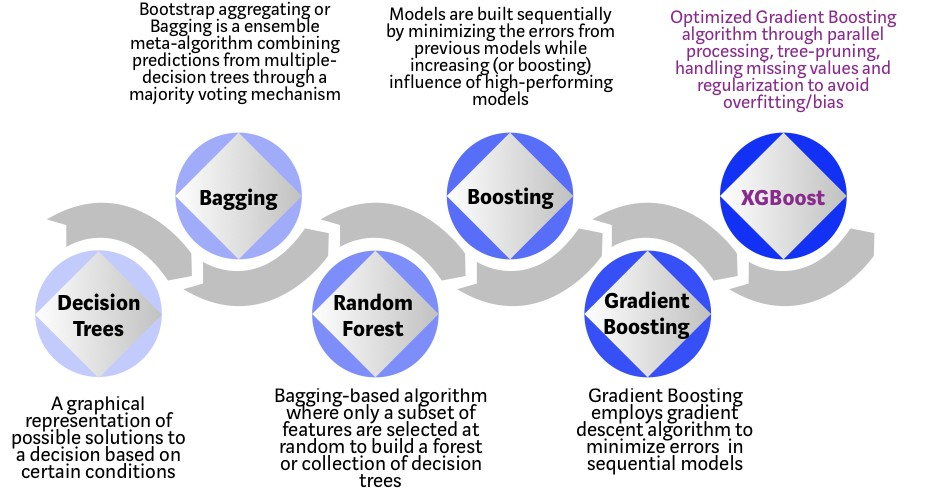

##### 6.2.9.1. Primera optimización de hiperparámetros

In [20]:
import json
from datetime import datetime
from hyperopt import fmin, hp, tpe, space_eval, Trials

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('HyperOpt Optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\\HyperOpt Optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

In [17]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
indexes = list([train_index for train_index, test_index in sss.split(X, y)][0])

X_train = X.iloc[indexes, :]
y_train = y.iloc[indexes]

# Definición del espacio / dominio de parámetros.
search_space = {'n_estimators' : hp.randint('a', 5, 1000),
                'max_depth' : hp.randint('b', 3, 20),
                'random_state' : 42, 
                'tree_method' : 'gpu_hist', 
                'gpu_id' : 0,
                'learning_rate' : hp.choice('c', [0.01, 0.05, 0.1, 0.15, 0.2])           
                }

# Definición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator, X_train, y_train
    start_time = time.time()
    i += 1
    
    clf = xgb.XGBClassifier(**search_space)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = clf, X = X_train, y = y_train, cv = skf, verbose = 0, n_jobs = -1, scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Ejecución del optimizador.
i = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate = rstate)

Trial: 0 | Loss: 0.1604 | Elapsed_time: 36.4993 seconds                                                                
Trial: 1 | Loss: 0.1427 | Elapsed_time: 8.9524 seconds                                                                 
Trial: 2 | Loss: 0.2046 | Elapsed_time: 6.2151 seconds                                                                 
Trial: 3 | Loss: 0.1485 | Elapsed_time: 5.9427 seconds                                                                 
Trial: 4 | Loss: 0.1527 | Elapsed_time: 21.3550 seconds                                                                
Trial: 5 | Loss: 0.1567 | Elapsed_time: 11.4025 seconds                                                                
Trial: 6 | Loss: 0.1535 | Elapsed_time: 3.6197 seconds                                                                 
Trial: 7 | Loss: 0.1461 | Elapsed_time: 14.5919 seconds                                                                
Trial: 8 | Loss: 0.1768 | Elapsed_time: 

In [25]:
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)


Best Trial:
Trial ID : 20
Loss : 0.13923520387039723
Params : {'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 287, 'random_state': 42, 'tree_method': 'gpu_hist'}

Json file: 20220301_110121.json

Scoring details:

      Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0   0.774704  0.965925  0.998369  0.999674   0.029126      0.012985  0.001234     0.000042  0.859526
1   0.794494   0.96523  0.998302  0.999697   0.027237      0.009593  0.002083     0.000028    0.8712
2   0.709294  0.979512   0.96284  0.999605   0.043339      0.008091  0.031919     0.000048  0.821845
3   0.794484  0.964809  0.999307  0.999697   0.029581      0.008046  0.000378     0.000042  0.871155
4   0.792969  0.957706  0.999231  0.999688   0.028462      0.012733  0.000328     0.000044  0.867366
5   0.788396  0.955667  0.999168   0.99968   0.029588      0.011742  0.000417     0.000044  0.863768
6    0.78689  0.963199  0.998906  0.999686   0.029056    

##### 6.2.9.2. Segunda optimización de hiperparámetros

In [28]:
# Params : {'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 287, 'random_state': 42, 'tree_method': 'gpu_hist'}

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
indexes = list([train_index for train_index, test_index in sss.split(X, y)][0])

X_train = X.iloc[indexes, :]
y_train = y.iloc[indexes]

# Definición del espacio / dominio de parámetros.
search_space = {'n_estimators' : 287,
                'max_depth' : 7,
                'random_state' : 42, 
                'tree_method' : 'gpu_hist', 
                'gpu_id' : 0,
                'learning_rate' : 0.05,
                'gamma' : hp.uniform('a', 0, 1),
                'min_child_weight' : hp.uniform('b', 0, 1),
                'max_delta_step' : hp.uniform('c', 0, 1),
                'subsample' : hp.uniform('d', 0, 1),
                'colsample_bytree' : hp.uniform('e', 0, 1),
                'colsample_bylevel' : hp.uniform('f', 0, 1),
                'colsample_bynode' : hp.uniform('g', 0, 1),
                'reg_alpha' : hp.uniform('h', 0, 1),
                'reg_lambda' : hp.uniform('i', 0, 1),
                'scale_pos_weight' : hp.uniform('j', 0, 1)
                }

# Definición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator, X_train, y_train
    start_time = time.time()
    i += 1
    
    clf = xgb.XGBClassifier(**search_space)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = clf, X = X_train, y = y_train, cv = skf, verbose = 0, n_jobs = -1, scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Ejecución del optimizador.
i = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate = rstate)

Trial: 0 | Loss: 1.0000 | Elapsed_time: 3.4508 seconds                                                                 
Trial: 1 | Loss: 1.0000 | Elapsed_time: 3.2265 seconds                                                                 
Trial: 2 | Loss: 1.0000 | Elapsed_time: 3.6712 seconds                                                                 
Trial: 3 | Loss: 1.0000 | Elapsed_time: 3.9724 seconds                                                                 
Trial: 4 | Loss: 1.0026 | Elapsed_time: 5.2749 seconds                                                                 
Trial: 5 | Loss: 0.2425 | Elapsed_time: 8.3376 seconds                                                                 
Trial: 6 | Loss: 1.0000 | Elapsed_time: 3.5965 seconds                                                                 
Trial: 7 | Loss: 1.0000 | Elapsed_time: 3.5351 seconds                                                                 
Trial: 8 | Loss: 0.8290 | Elapsed_time: 

In [29]:
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)


Best Trial:
Trial ID : 23
Loss : 0.15968534566137652
Params : {'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 'min_child_weight': 0.7431045276160863, 'n_estimators': 287, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

Json file: 20220301_112146.json

Scoring details:

      Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0        0.0       0.0  0.732324  0.998709        0.0           0.0  0.026705     0.000003       0.0
1        0.0       0.0       0.5  0.998709        0.0           0.0       0.0     0.000003       0.0
2        0.0       0.0  0.911633  0.998709        0.0           0.0  0.021581     0.000003   

##### 6.2.9.3. Tercera optimización de hiperparámetros

In [31]:
# Params : {'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 
# 'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 
# 'min_child_weight': 0.7431045276160863, 'n_estimators': 287, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 
# 'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
indexes = list([train_index for train_index, test_index in sss.split(X, y)][0])

X_train = X.iloc[indexes, :]
y_train = y.iloc[indexes]

# Definición del espacio / dominio de parámetros.
search_space = {'n_estimators': hp.randint('a', 1, 1000), 'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 
                'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 
                'min_child_weight': 0.7431045276160863, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 
                'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

# Definición de la función objetivo.
def objective_func(search_space):
    
    global i, scorings, estimator, X_train, y_train
    start_time = time.time()
    i += 1
    
    clf = xgb.XGBClassifier(**search_space)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    cv = cross_validate(estimator = clf, X = X_train, y = y_train, cv = skf, verbose = 0, n_jobs = -1, scoring = ('precision', 'recall', 'roc_auc', 'accuracy', 'f1'))
    
    loss = 1 - cv['test_f1'].mean() + cv['test_f1'].std()

    scorings.append({'trial': i,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': cv['test_recall'].mean(),
                                   'Precision': cv['test_precision'].mean(),
                                   'AUC': cv['test_roc_auc'].mean(),
                                   'Accuracy': cv['test_accuracy'].mean(),
                                   'Recall_Std': cv['test_recall'].std(),
                                   'Precision_Std': cv['test_precision'].std(),
                                   'AUC_Std': cv['test_roc_auc'].std(),
                                   'Accuracy_Std': cv['test_accuracy'].std(),
                                   'F1-Score': cv['test_f1'].mean()}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (i, loss, elapsed_time))
    
    return loss

# Ejecución del optimizador.
i = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20, trials = trials, rstate = rstate)

Trial: 0 | Loss: 1.0000 | Elapsed_time: 1.2411 seconds                                                                 
Trial: 1 | Loss: 0.1482 | Elapsed_time: 30.3693 seconds                                                                
Trial: 2 | Loss: 0.4813 | Elapsed_time: 4.2402 seconds                                                                 
Trial: 3 | Loss: 0.1481 | Elapsed_time: 23.0924 seconds                                                                
Trial: 4 | Loss: 0.1581 | Elapsed_time: 10.8071 seconds                                                                
Trial: 5 | Loss: 0.1482 | Elapsed_time: 26.5306 seconds                                                                
Trial: 6 | Loss: 0.1482 | Elapsed_time: 27.0549 seconds                                                                
Trial: 7 | Loss: 0.1560 | Elapsed_time: 17.4966 seconds                                                                
Trial: 8 | Loss: 1.0000 | Elapsed_time: 

In [32]:
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)


Best Trial:
Trial ID : 3
Loss : 0.14813874213581021
Params : {'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 'min_child_weight': 0.7431045276160863, 'n_estimators': 630, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

Json file: 20220301_114133.json

Scoring details:

      Recall Precision       AUC  Accuracy Recall_Std Precision_Std   AUC_Std Accuracy_Std  F1-Score
0        0.0       0.0  0.519754  0.998709        0.0           0.0  0.002624     0.000003       0.0
1   0.776247  0.979217  0.998318   0.99969   0.022634      0.013991  0.001906      0.00003  0.865734
2   0.397145       1.0  0.994407  0.999222   0.047902           0.0  0.001127      0.00006   0

##### 6.2.9.4. Evaluación en el conjunto de validación

In [36]:
# Evaluación con el conjunto de validación.
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

params = {'n_estimators': 630, 'colsample_bylevel': 0.67144859255828, 'colsample_bynode': 0.7831315094844271, 'colsample_bytree': 0.8014899183766985, 
            'gamma': 0.014974393635115657, 'gpu_id': 0, 'learning_rate': 0.05, 'max_delta_step': 0.9959894166399985, 'max_depth': 7, 
            'min_child_weight': 0.7431045276160863, 'random_state': 42, 'reg_alpha': 0.5395766188121431, 'reg_lambda': 0.3611246194409444, 
            'scale_pos_weight': 0.9983922138002084, 'subsample': 0.9933497238368184, 'tree_method': 'gpu_hist'}

clf = xgb.XGBClassifier(**params)

X_train = X
y_train = y

X_test = df_validation.drop(labels = ['isFraud', 'isFlaggedFraud'], axis = 1, inplace = False)
y_test = df_validation['isFraud']

clf.fit(X = X_train, y = y_train)

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

[11:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall: 0.8357
Precision: 0.9744
AUC: 0.9178
Accuracy: 0.9998
F1-Score: 0.8997
